# Figure 2a - Codes for preparing Land-use Ankara

## 1 - Import Necessary Modules

In [2]:
import cartopy 
import cartopy.io.shapereader as shpreader 
import cartopy.io.shapereader as Reader 
import geopandas as gpd
import matplotlib.pyplot as plt 
import numpy as np 
import proplot as plot
import proplot
import salem
import xarray as xr 

from cartopy.feature import ShapelyFeature 
from glob import glob
from mpl_toolkits.axes_grid1.inset_locator import inset_axes 
from netCDF4 import Dataset 
from shapely.geometry import mapping
from visjobs.visualize import easy_plot
from wrf import getvar, interpline, CoordPair, xy_to_ll, ll_to_xy 

# warnings
import warnings
warnings.filterwarnings('ignore')

## 2. Open data and define map projections

In [2]:
dt1_aid = Dataset(r'datasets/summer_run_input/ankara_wsm6_urban/wrfinput_d03')
dt1 = xr.open_dataset(r'datasets/summer_run_input/ankara_wsm6_urban/wrfinput_d03')

sol_alt = xy_to_ll(dt1_aid, x=0, y=0).values
sol_ust = xy_to_ll(dt1_aid, x=0, y=200).values
sag_ust = xy_to_ll(dt1_aid, x=200, y=200).values
sag_alt = xy_to_ll(dt1_aid, x=200, y=0).values

urban_sol_alt = ll_to_xy(dt1_aid, longitude = 32.495, latitude = 39.81)
urban_sol_ust = ll_to_xy(dt1_aid, longitude = 32.495, latitude = 40.085)
urban_sag_alt = ll_to_xy(dt1_aid, longitude = 33, latitude = 39.81)
urban_sag_ust = ll_to_xy(dt1_aid, longitude = 33, latitude = 40.085)

lats = dt1['XLAT']
lons = dt1['XLONG']
lu_index = dt1['LU_INDEX']

cart_proj = cartopy.crs.LambertConformal( 32.834, 39.873 )

In [3]:
dt2 = dt1.copy(deep=True)

In [4]:
for i in range(len(dt2['Time'])):
    for j in range(len(dt2['south_north'])):
        for z in range(len(dt2['west_east'])):
            query_x = [z>=urban_sol_alt[0].values, z<=urban_sag_alt[0].values, 
                       j>=urban_sag_alt[1].values, j<=urban_sag_ust[1].values]
            if all(query_x)==True and dt2['LU_INDEX'][i,j,z]==1:
                dt2['LU_INDEX'][i,j,z]=2

In [5]:
lu_index2 = dt2['LU_INDEX']

In [6]:
# color bar creation
cb_list = ['#f00',
           '#fffcd7',
           '#797100',
           '#009d86',
           '#70cdc0',
           '#c8bb27',
           '#00b900',
           '#009200',
           '#006900',
           '#9be3ff',
           '#929292',
           '#fcee81'
          ]


# make a color map of fixed colors
unique = np.unique(lu_index[0])
cmap = matplotlib.colors.ListedColormap(cb_list)
bounds= np.concatenate([np.array([0]), unique,])
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N,)

shape_path = r'\ShapeFiles\tur_polbnda_adm1.shp'

## 3. Plot

C:\Users\User\anaconda3\envs\berkay\lib\site-packages\proplot\figure.py:94: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  result = func(self, *args, **kwargs)
C:\Users\User\anaconda3\envs\berkay\lib\site-packages\proplot\figure.py:94: MatplotlibDeprecationWarning: 
The 'progressive' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'progressive': ...} instead. If any parameter follows 'progressive', they should be passed as keyword, not positionally.
  result = func(self, *args, **kwargs)


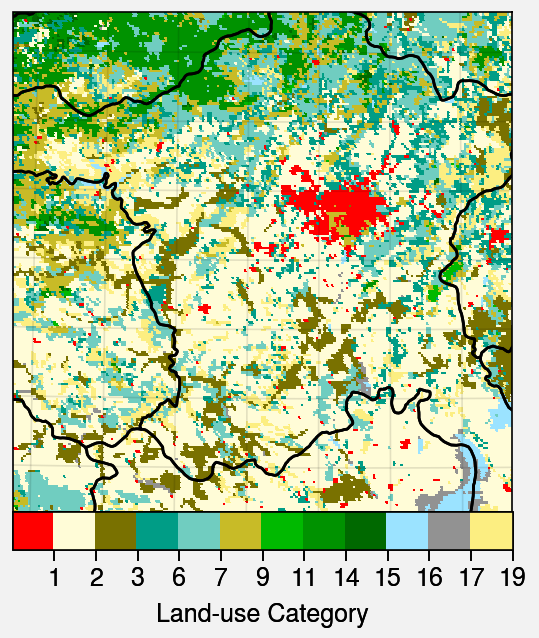

In [8]:
# Starting the plotting
fig, axs = plot.subplots(ncols=1, nrows=1, proj=cart_proj)
axs.set_extent([sol_alt[1], sag_alt[1], sol_alt[0], sol_ust[0]])


# format the plot
axs.format(
    coast = False,
    labels=False, innerborders=False, reso = 'xx-hi', coastlinewidth = 0.5, innerborderslinewidth = 0.5,
    land = False, landcolor = '#f0e7d8', landzorder = 0.005, borderszorder = 3, innerborderszorder = 3, 
    abc=False, abcstyle='(a)', abcloc='ur', )
axs.format()

# province borders
shp_file_il = cartopy.io.shapereader.Reader(shape_path)

shape_feature_il = ShapelyFeature(shp_file_il.geometries(),
                                    cartopy.crs.PlateCarree(), edgecolor='black', linewidths=1,
                                    facecolor='none', zorder=1.5)

# -------------------------------------------------------
# add shapefile features   
axs.add_feature(shape_feature_il) 

# labels
#axs[0].format(ultitle = '{}'.format('Urban Configuration'), titlesize=13, titleweight='bold' )
#axs[1].format(ultitle = '{}'.format('Nourban Configuration'), titlesize=13, titleweight='bold' )

# draw lu_index
interval = unique

m=axs[0].pcolormesh(lons.values[0], lats.values[0], lu_index[0]-0.5, norm=norm, cmap=cmap, 
                 transform=cartopy.crs.PlateCarree(), zorder = 0.01,)
#axs[1].pcolormesh(lons.values[0], lats.values[0], lu_index2[0]-0.5, norm=norm, cmap=cmap, 
#                transform=cartopy.crs.PlateCarree(), zorder = 0.01,)

fig.colorbar(m, label='Land-use Category', 
             ticks = unique, loc = 'b', norm=norm, space=0)#Adding colorbar with label

#save figure
plt.savefig(r'pictures/Urban_Configurations_v2.jpeg',
              bbox_inches='tight', optimize=True, progressive=True, dpi=500)